In [2]:
!pip install mlflow

  Using cached mlflow-2.22.0-py3-none-any.whl.metadata (30 kB)
  Using cached mlflow_skinny-2.22.0-py3-none-any.whl.metadata (31 kB)
  Using cached flask-3.1.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphene-3.4.3-py2.py3-none-any.whl.metadata (6.9 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached pyarrow-19.0.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (3.3 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached scipy-1.15.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached sqlalchemy-2.0.41-cp312-cp312-macosx_11_0_arm64.whl.met

In [5]:
!pip install seaborn

85.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [12]:
!pip install opencv-python

224.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl (37.3 MB)


In [13]:
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

from sklearn.metrics import classification_report, confusion_matrix
import ssl
import cv2

In [14]:
BASE_DIR = "../wildsnap-dataset"
BATCH_SIZE = 32
EPOCHS = 10

backbones = {
    "MobileNetV2": MobileNetV2,
    "EfficientNetB0": EfficientNetB0,
    "EfficientNetB4": EfficientNetB4,
}

recommended_sizes = {
    "MobileNetV2": (224, 224),
    "EfficientNetB0": (224, 224),
    "EfficientNetB4": (380, 380),
}

results = {}

In [15]:
train_dir = os.path.join(BASE_DIR, 'train')
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name)))
                for class_name in os.listdir(train_dir)}

print("Class Distribution in Train Set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

Class Distribution in Train Set:
Budapest Highflyer: 11 images
Yellow Ring-necked Parakeet: 15 images
Grey Parrot: 11 images
Muscovy Duck: 12 images
Crowned Cranes: 16 images
Blue-and-yellow macaw: 14 images


In [16]:
# Show image shape and type
sample_path = os.path.join(train_dir, list(class_counts.keys())[0], os.listdir(os.path.join(train_dir, list(class_counts.keys())[0]))[0])
sample_img = cv2.imread(sample_path)
print(f"Sample image shape: {sample_img.shape}, dtype: {sample_img.dtype}")

Sample image shape: (4032, 3024, 3), dtype: uint8


In [8]:
import sys
!{sys.executable} -m pip install shap

  Using cached shap-0.47.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.61.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.8 kB)
  Using cached llvmlite-0.44.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.8 kB)
Using cached shap-0.47.2-cp312-cp312-macosx_11_0_arm64.whl (546 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.61.2-cp312-cp312-macosx_11_0_arm64.whl (2.8 MB)
Using cached llvmlite-0.44.0-cp312-cp312-macosx_11_0_arm64.whl (26.2 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [shap]4/5 [shap]]te]


In [17]:
from tensorflow.keras.models import load_model

import shap
import tensorflow as tf

/Users/smileyfacez/ml_models/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_path = "../model/weight-model/MobileNetV2.h5"
model = load_model(model_path)

print(f"Model loaded from {model_path}")

Model loaded from ./MobileNetV2.h5


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    "../wildsnap-dataset/test",     
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 20 images belonging to 6 classes.


In [29]:
x_test, y_test = next(test_gen)
print("x_test shape:", x_test.shape)

x_test shape: (20, 224, 224, 3)


/Users/smileyfacez/ml_models/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(3, 224, 224, 3))']
  warnings.warn(msg)
/Users/smileyfacez/ml_models/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

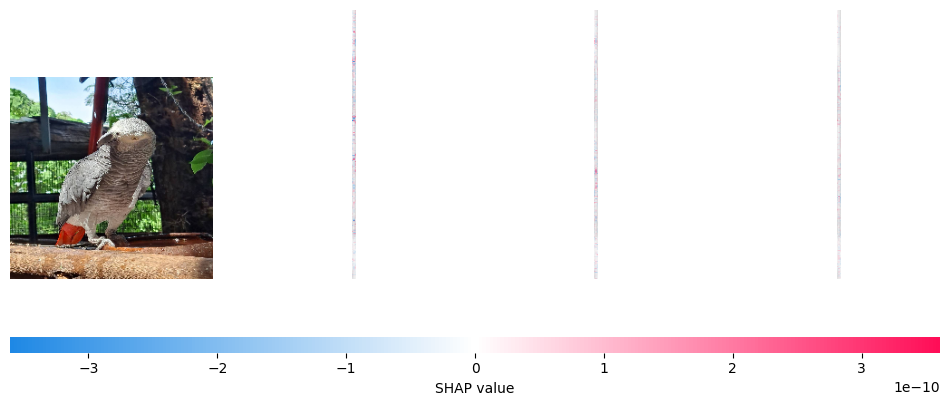

<Figure size 640x480 with 0 Axes>

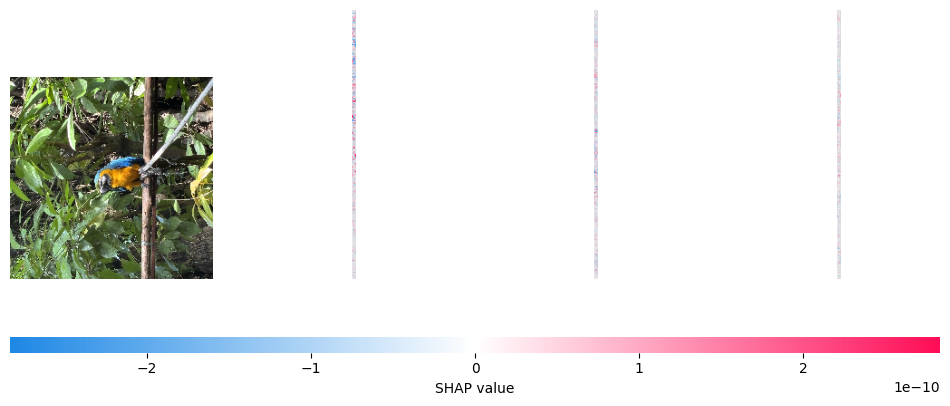

<Figure size 640x480 with 0 Axes>

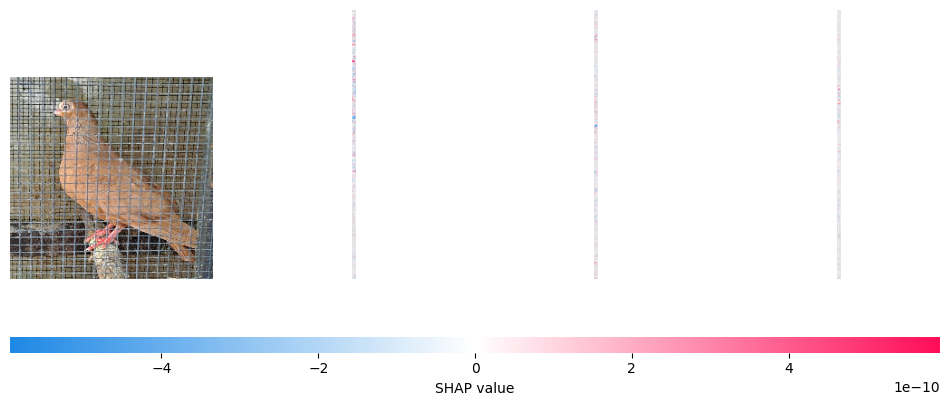

In [30]:
background = x_test[:10]
samples = x_test[:3]

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(samples)

# Plot SHAP explanations
for i in range(3):
    plt.figure()
    shap.image_plot(
        [shap_values[c][i] for c in range(len(shap_values))],
        samples[i]
    )
    plt.savefig(f"shap_explanation_sample_{i+1}.png")
    plt.close()


In [29]:
all_values = np.concatenate([v.flatten() for v in shap_values])
print("SHAP value range:", np.min(all_values), "to", np.max(all_values))

SHAP value range: -0.014513717032968998 to 0.013401214964687824
